In [1]:
import cv2
import numpy as np
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image
import matplotlib.pyplot as plt

In [ ]:
# Initialize InsightFace app (download models on first run)
app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])  # Use 'CUDAExecutionProvider' for GPU
app.prepare(ctx_id=0)

In [17]:
# Load two face images
img1 = cv2.imread(r"C:\Users\Corei5_8GBRAM_512SSD\OneDrive\Desktop\Face_Detection_Attendance_Tracker_Project\pic1.jpg")
img2 = cv2.imread(r"C:\Users\Corei5_8GBRAM_512SSD\OneDrive\Desktop\Face_Detection_Attendance_Tracker_Project\pic10.jpg")

# Convert BGR to RGB
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Get face info and embeddings
faces1 = app.get(img1_rgb)
faces2 = app.get(img2_rgb)

# Check that at least one face is detected in each image
if not faces1 or not faces2:
    print("No face detected in one or both images!")
    exit()

# Get the 512D face embedding
embedding1 = faces1[0].embedding
embedding2 = faces2[0].embedding

# Compare embeddings using cosine similarity
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

similarity = cosine_similarity(embedding1, embedding2)
print(f"Cosine Similarity: {similarity:.4f}")

# Threshold for same person (generally > 0.35 means likely same person)
if similarity > 0.35:
    print("✅ Faces Match (Same Person)")
else:
    print("❌ Faces Do Not Match")

# Optional: Display both images
plt.subplot(1, 2, 1)
plt.imshow(img1_rgb)
plt.title("Person 1")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img2_rgb)
plt.title("Person 2")
plt.axis("off")
plt.show()

Cosine Similarity: 0.7505
✅ Faces Match (Same Person)


In [ ]:
import os
from sklearn.metrics.pairwise import cosine_similarity

In [20]:
# Path to known faces
known_faces_dir = "known_faces"

# Load and compute embeddings for known faces
known_embeddings = []
known_labels = []

for filename in os.listdir(known_faces_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(known_faces_dir, filename)
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        faces = app.get(img_rgb)
        if not faces:
            print(f"[!] No face detected in {filename}, skipping.")
            continue

        embedding = faces[0].embedding
        label = os.path.splitext(filename)[0]
        known_embeddings.append(embedding)
        known_labels.append(label)

# Load the test image
test_img_path = "pic1.jpg"
test_img = cv2.imread(test_img_path)
test_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

test_faces = app.get(test_rgb)
if not test_faces:
    print("[!] No face detected in test image.")
    exit()

test_embedding = test_faces[0].embedding

# Compute cosine similarities
similarities = cosine_similarity([test_embedding], known_embeddings)[0]

# Find best match
best_match_index = np.argmax(similarities)
best_match_label = known_labels[best_match_index]
best_similarity = similarities[best_match_index]

# Output results
print(f"\nMost similar face: {best_match_label}")
print(f"Cosine Similarity: {best_similarity:.4f}")

# Thresholding
if best_similarity > 0.35:
    print("✅ Match Found")
else:
    print("❌ No confident match found")


Most similar face: pic4
Cosine Similarity: 0.8345
✅ Match Found


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Corei5_8GBRAM_512SSD/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Corei5_8GBRAM_512SSD/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Corei5_8GBRAM_512SSD/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Corei5_8GBRAM_512SSD/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Corei5_8GBRAM_512SSD/.insight

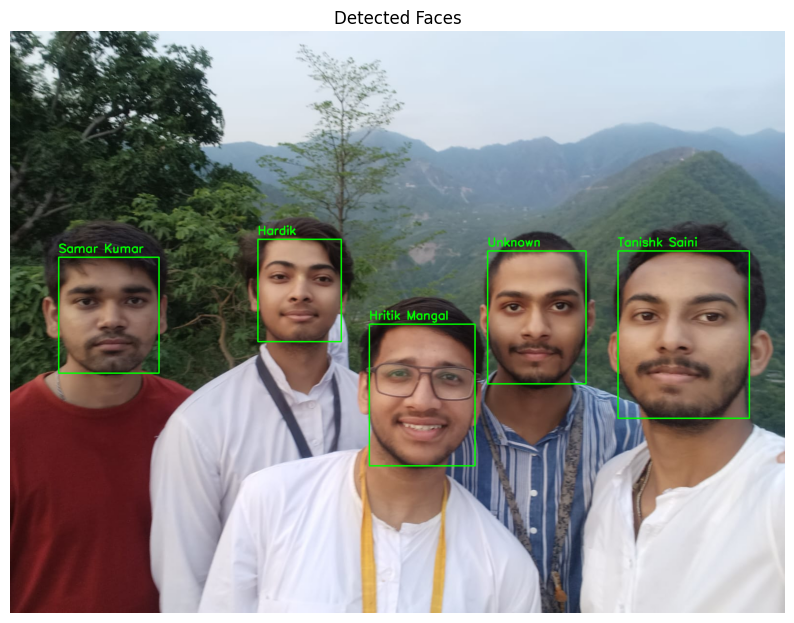

In [7]:
import os
import cv2
import numpy as np
from insightface.app import FaceAnalysis
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Initialize the model
app = FaceAnalysis(name='buffalo_l', providers=['CPUExecutionProvider'])  # Use 'CUDAExecutionProvider' for GPU
app.prepare(ctx_id=0)

# --- STEP 1: LOAD KNOWN FACES ---
known_dir = "known_faces1"
known_embeddings = []
known_names = []

for file in os.listdir(known_dir):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        path = os.path.join(known_dir, file)
        img = cv2.imread(path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        faces = app.get(img_rgb)
        if not faces:
            print(f"[!] No face detected in {file}")
            continue
        known_embeddings.append(faces[0].embedding)
        known_names.append(os.path.splitext(file)[0])
print(f"✅ Loaded {len(known_names)} known faces")

# --- STEP 2: DETECT FACES IN GROUP PHOTO ---
group_image = cv2.imread("test4.jpg")
group_rgb = cv2.cvtColor(group_image, cv2.COLOR_BGR2RGB)
group_faces = app.get(group_rgb)

if not group_faces:
    print("❌ No faces detected in group photo.")
    exit()

# --- STEP 3: MATCH EACH DETECTED FACE TO KNOWN FACES ---
detected_names = []

for face in group_faces:
    group_embedding = face.embedding
    similarities = cosine_similarity([group_embedding], known_embeddings)[0]
    best_match_idx = np.argmax(similarities)
    best_similarity = similarities[best_match_idx]
    name = known_names[best_match_idx]

    if best_similarity > 0.35:  # Threshold for match
        detected_names.append(name)
        print(f"✅ Detected: {name} (Similarity: {best_similarity:.2f})")
    else:
        print(f"❌ Unknown face (Best similarity: {best_similarity:.2f})")

# --- STEP 4: Display Group Image with Labels ---
for face in group_faces:
    box = face.bbox.astype(int)
    group_embedding = face.embedding
    similarities = cosine_similarity([group_embedding], known_embeddings)[0]
    best_match_idx = np.argmax(similarities)
    best_similarity = similarities[best_match_idx]

    if best_similarity > 0.35:
        label = known_names[best_match_idx]
    else:
        label = "Unknown"

    cv2.rectangle(group_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
    cv2.putText(group_image, label, (box[0], box[1]-10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

# Show final image
# cv2.imshow("Group Photo - Detection", group_image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

# Convert BGR to RGB for matplotlib
group_image_rgb = cv2.cvtColor(group_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(group_image_rgb)
plt.axis("off")
plt.title("Detected Faces")
plt.show()
